In [1]:
from google.colab import files
uploaded = files.upload()

Saving SEntFiN.csv to SEntFiN (2).csv


In [2]:
!pip -q install transformers datasets evaluate accelerate scikit-learn torch torchvision torchaudio

Load the Dataset into a DataFrame

In [3]:
import pandas as pd

df = pd.read_csv("SEntFiN.csv")
print("Dataset shape:", df.shape)
df.head(5)

Dataset shape: (10753, 4)


,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,{'SpiceJet': 'neutral'},8
1,2,MMTC Q2 net loss at Rs 10.4 crore,{'MMTC': 'neutral'},8
2,3,"Mid-cap funds can deliver more, stay put: Experts",{'Mid-cap funds': 'positive'},8
3,4,Mid caps now turn into market darlings,{'Mid caps': 'positive'},7
4,5,"Market seeing patience, if not conviction: Pra...",{'Market': 'neutral'},8


Extract Entity & Sentiment

In [4]:
import ast

entities = []
sentiments = []

for i, decision in enumerate(df['Decisions']):
    try:
        parsed = ast.literal_eval(decision)
        entity = list(parsed.keys())[0]
        sentiment = list(parsed.values())[0]
        entities.append(entity)
        sentiments.append(sentiment)
    except:
        entities.append(None)
        sentiments.append(None)

df['entity'] = entities
df['sentiment'] = sentiments

df = df[['Title', 'entity', 'sentiment']].dropna().drop_duplicates()
df.columns = ['headline', 'entity', 'sentiment']

print("After cleaning:", df.shape)
df.head(5)

After cleaning: (10683, 3)


,headline,entity,sentiment
0,SpiceJet to issue 6.4 crore warrants to promoters,SpiceJet,neutral
1,MMTC Q2 net loss at Rs 10.4 crore,MMTC,neutral
2,"Mid-cap funds can deliver more, stay put: Experts",Mid-cap funds,positive
3,Mid caps now turn into market darlings,Mid caps,positive
4,"Market seeing patience, if not conviction: Pra...",Market,neutral


Check Sentiment Distribution

In [5]:
df['sentiment'].value_counts()

,count
sentiment,
positive,4146
neutral,3411
negative,3126


Encode Labels as Numbers

In [6]:
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}

df['label'] = df['sentiment'].map(label2id)
df[['headline', 'entity', 'sentiment', 'label']].head(5)


,headline,entity,sentiment,label
0,SpiceJet to issue 6.4 crore warrants to promoters,SpiceJet,neutral,1
1,MMTC Q2 net loss at Rs 10.4 crore,MMTC,neutral,1
2,"Mid-cap funds can deliver more, stay put: Experts",Mid-cap funds,positive,2
3,Mid caps now turn into market darlings,Mid caps,positive,2
4,"Market seeing patience, if not conviction: Pra...",Market,neutral,1


Train / Validation / Test Split

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df['label'], random_state=42)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

Train size: 7718
Validation size: 1362
Test size: 1603


Convert to Hugging Face Dataset Format

In [8]:
from datasets import Dataset, DatasetDict

def make_input(row):
    return f"{row['headline']} [TGT] {row['entity']}"

train_df["text"] = train_df.apply(make_input, axis=1)
val_df["text"]   = val_df.apply(make_input, axis=1)
test_df["text"]  = test_df.apply(make_input, axis=1)

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df[['text', 'label']], preserve_index=False),
    "validation": Dataset.from_pandas(val_df[['text', 'label']], preserve_index=False),
    "test": Dataset.from_pandas(test_df[['text', 'label']], preserve_index=False),
})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 7718
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1362
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1603
    })
})

Load Tokenizer & Add [TGT] Token

In [9]:
from transformers import AutoTokenizer

MODEL_NAME = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

special_tokens_dict = {"additional_special_tokens": ["[TGT]"]}
tokenizer.add_special_tokens(special_tokens_dict)

print("Tokenizer vocab size:", len(tokenizer))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenizer vocab size: 30523


Tokenize the Dataset

In [10]:
from transformers import DataCollatorWithPadding

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)

tokenized = dataset.map(tokenize, batched=True, remove_columns=["text"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized

Map:   0%|          | 0/7718 [00:00<?, ? examples/s]

Map:   0%|          | 0/1362 [00:00<?, ? examples/s]

Map:   0%|          | 0/1603 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7718
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1362
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1603
    })
})

In [11]:
import torch
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label={0: "negative", 1: "neutral", 2: "positive"},
    label2id={"negative": 0, "neutral": 1, "positive": 2},
)

model.resize_token_embeddings(len(tokenizer))

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

device

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


'cpu'

Load the FinBERT Model

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

In [13]:
!pip install -U transformers

In [19]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="finbert_sentiment",
    save_steps=500,
    logging_steps=100,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    report_to=[]
)


In [22]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-3825733424.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [24]:
small_train = tokenized["train"].shuffle(seed=42).select(range(2000))
small_val = tokenized["validation"].shuffle(seed=42).select(range(500))

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

/tmp/ipython-input-3056971847.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,0.952800
200,0.625300
300,0.420300
400,0.338100
500,0.361800


TrainOutput(global_step=500, training_loss=0.5396914978027344, metrics={'train_runtime': 1385.7346, 'train_samples_per_second': 2.887, 'train_steps_per_second': 0.361, 'total_flos': 55915712414352.0, 'train_loss': 0.5396914978027344, 'epoch': 2.0})

Metrics Function (Accuracy, F1)

In [25]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

predictions = trainer.predict(tokenized["test"])
y_true = np.array(tokenized["test"]["label"])
y_pred = np.argmax(predictions.predictions, axis=-1)

acc = accuracy.compute(predictions=y_pred, references=y_true)["accuracy"]
f1_macro = f1.compute(predictions=y_pred, references=y_true, average="macro")["f1"]

print(f"Accuracy: {acc:.4f}")
print(f"F1 (Macro): {f1_macro:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["negative","neutral","positive"]))

cm = confusion_matrix(y_true, y_pred)
pd.DataFrame(cm, index=["True Neg","True Neu","True Pos"], columns=["Pred Neg","Pred Neu","Pred Pos"])


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 0.8297
F1 (Macro): 0.8278

Classification Report:

              precision    recall  f1-score   support

    negative       0.88      0.78      0.83       469
     neutral       0.78      0.81      0.80       512
    positive       0.84      0.88      0.86       622

    accuracy                           0.83      1603
   macro avg       0.83      0.82      0.83      1603
weighted avg       0.83      0.83      0.83      1603



,Pred Neg,Pred Neu,Pred Pos
True Neg,367,61,41
True Neu,29,417,66
True Pos,19,57,546


In [26]:
model_dir = "finbert_news_sentiment"
trainer.model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

clean_path = "SEntFiN_clean.csv"
df.to_csv(clean_path, index=False)

print(" Model and dataset saved!")


 Model and dataset saved!


In [27]:
def predict_sentiment(headline: str, entity: str):
    """Predict sentiment for a custom news headline and entity."""
    text = f"{headline.strip()} [TGT] {entity.strip()}"
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
        pred_label = np.argmax(probs)
    return {
        "headline": headline,
        "entity": entity,
        "predicted_sentiment": ["negative", "neutral", "positive"][pred_label],
        "confidence_scores": {
            "negative": round(float(probs[0]), 4),
            "neutral": round(float(probs[1]), 4),
            "positive": round(float(probs[2]), 4),
        }
    }

predict_sentiment("Government unveils major tax relief package for startups", "Government")

{'headline': 'Government unveils major tax relief package for startups',
 'entity': 'Government',
 'predicted_sentiment': 'neutral',
 'confidence_scores': {'negative': 0.0265,
  'neutral': 0.9643,
  'positive': 0.0092}}

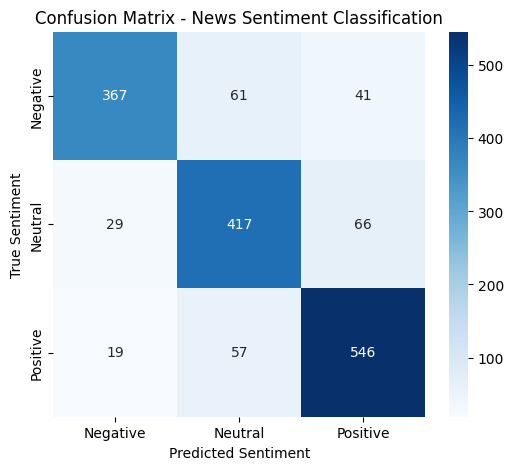

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
labels = ["Negative", "Neutral", "Positive"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Sentiment")
plt.ylabel("True Sentiment")
plt.title("Confusion Matrix - News Sentiment Classification")
plt.show()